# BindsNET Neuron (Node) Models

## 1. Table of Contents
1. Table of Contents
2. Overview
3. Import Statements
4. Neuron Models
    1. Integrate-and-Fire (IF)
    2. Leaky Integrate-and-Fire (LIF)
    3. Spike Response Model 0 (SRM0)


## 2. Overview
Detailed documentation of the node creation process has been specified [here](https://bindsnet-docs.readthedocs.io/guide/guide_part_i.html#creating-a-network). This document will go into more specific examples of configuring a spiking neural network in BindsNET.

## 3. Import Statements

In [141]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from bindsnet.encoding import *
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, IFNodes, SRM0Nodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor

from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_input, plot_weights

## 4. Neuron Models

### 4a. Integrate-and-Fire (IF) Model
Incoming spikes are integrated (added) to the membrane potential
### Parameters
Below is a table that describes the parameters that can be tweaked to customize the LIF Neuron model.

| Parameter       | Type                       | Description                                   | Default Value |
|-----------------|----------------------------|-----------------------------------------------|---------------|
| n               | Optional\[int]              | The number of neurons in the layer.           | None          |
| shape           | Optional\[Iterable\[int]]    | The dimensionality of the layer.              | None          |
| traces          | bool                       | Whether to record spike traces.               | False         |
| traces_additive | bool                       | Whether to record spike traces additively.    | False         |
| tc_trace        | Union\[float, torch.Tensor] | Time constant of spike trace decay.           | 20.0          |
| trace_scale     | Union\[float, torch.Tensor] | Scaling factor for spike trace.               | 1.0           |
| sum_input       | bool                       | Whether to sum all inputs.                    | False         |
| thresh          | Union\[float, torch.Tensor] | Spike threshold voltage.                      | -52.0         |
| rest            | Union\[float, torch.Tensor] | Resting membrane voltage.                     | -65.0         |
| reset           | Union\[float, torch.Tensor] | Post-spike reset voltage.                     | -65.0         |
| refrac          | Union\[int, torch.Tensor]   | Refractory (non-firing) period of the neuron. | 5             |
| tc_decay        | Union\[float, torch.Tensor] | Time constant of neuron voltage decay.        | 100.0         |
| lbound          | float                      | Lower bound of the voltage.                   | None          |



### 4b. Leaky Integrate-and-Fire (LIF) Model
Incoming spikes are integrated (added) to the membrane potential. The membrane potential decrements at each timestep.
### Parameters
Below is a table that describes the parameters that can be tweaked to customize the LIF Neuron model.

| Parameter       | Type                       | Description                                   | Default Value |
|-----------------|----------------------------|-----------------------------------------------|---------------|
| n               | Optional\[int]              | The number of neurons in the layer.           | None          |
| shape           | Optional\[Iterable\[int]]    | The dimensionality of the layer.              | None          |
| traces          | bool                       | Whether to record spike traces.               | False         |
| traces_additive | bool                       | Whether to record spike traces additively.    | False         |
| tc_trace        | Union\[float, torch.Tensor] | Time constant of spike trace decay.           | 20.0          |
| trace_scale     | Union\[float, torch.Tensor] | Scaling factor for spike trace.               | 1.0           |
| sum_input       | bool                       | Whether to sum all inputs.                    | False         |
| thresh          | Union\[float, torch.Tensor] | Spike threshold voltage.                      | -52.0         |
| rest            | Union\[float, torch.Tensor] | Resting membrane voltage.                     | -65.0         |
| reset           | Union\[float, torch.Tensor] | Post-spike reset voltage.                     | -65.0         |
| refrac          | Union\[int, torch.Tensor]   | Refractory (non-firing) period of the neuron. | 5             |
| tc_decay        | Union\[float, torch.Tensor] | Time constant of neuron voltage decay.        | 100.0         |
| lbound          | float                      | Lower bound of the voltage.                   | None          |

### 4c. Spike Response Model 0 (SRM0)
Incoming spikes are integrated (added) to the membrane potential. The membrane potential decrements at each timestep.
### Parameters
Below is a table that describes the parameters that can be tweaked to customize the LIF Neuron model.

| Parameter       | Type                       | Description                                   | Default Value |
|-----------------|----------------------------|-----------------------------------------------|---------------|
| n               | Optional\[int]              | The number of neurons in the layer.           | None          |
| shape           | Optional\[Iterable\[int]]    | The dimensionality of the layer.              | None          |
| traces          | bool                       | Whether to record spike traces.               | False         |
| traces_additive | bool                       | Whether to record spike traces additively.    | False         |
| tc_trace        | Union\[float, torch.Tensor] | Time constant of spike trace decay.           | 20.0          |
| trace_scale     | Union\[float, torch.Tensor] | Scaling factor for spike trace.               | 1.0           |
| sum_input       | bool                       | Whether to sum all inputs.                    | False         |
| thresh          | Union\[float, torch.Tensor] | Spike threshold voltage.                      | -52.0         |
| rest            | Union\[float, torch.Tensor] | Resting membrane voltage.                     | -65.0         |
| reset           | Union\[float, torch.Tensor] | Post-spike reset voltage.                     | -65.0         |
| refrac          | Union\[int, torch.Tensor]   | Refractory (non-firing) period of the neuron. | 5             |
| tc_decay        | Union\[float, torch.Tensor] | Time constant of neuron voltage decay.        | 100.0         |
| lbound          | float                      | Lower bound of the voltage.                   | None          |

<!--
Tables generated using https://www.tablesgenerator.com/markdown_tables#
-->

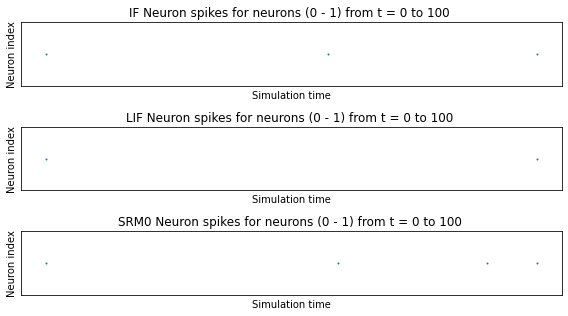

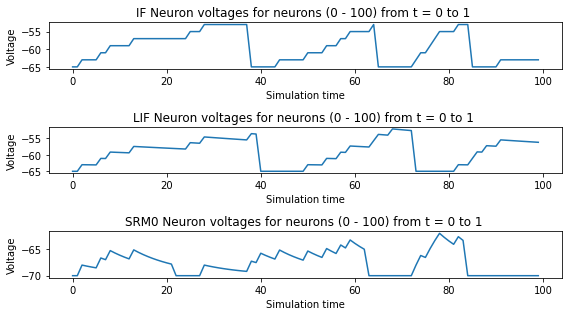

In [149]:
# initialize network
network = Network()
network = Network()

# set number of neurons
num_inputs = 1
num_neurons = 1

# simulation time
time = 100
dt = 1

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(num_inputs, num_neurons)))

# create input spike data, where each spike is distributed according to Bernoulli(0.1)
input_data = torch.bernoulli(0.3 * torch.ones(time, num_inputs)).byte()
inputs = {"Input Layer": input_data}

# initialize list of neuron models
neuron_models = [IFNodes(n=num_neurons),LIFNodes(n=num_neurons),SRM0Nodes(n=num_neurons)]
neuron_types = ["IF Neuron","LIF Neuron","SRM0 Neuron"]
spikes={}
voltages={}

for neuron_model_index in range(len(neuron_models)):
    # initialize input and neuron layers
    input_layer = Input(n=num_inputs)
    neuron_layer = neuron_models[neuron_model_index]

    # connection between the input layer and the LIF layer
    connection = Connection(
        source=input_layer, target=neuron_layer,w=w
    )

    # create a monitor
    neuron_layer_monitor = Monitor(
        obj=neuron_layer,
        state_vars=("s", "v"),  # Record spikes and voltages.
        time=time,  # Length of simulation (if known ahead of time).
    )

    # add layers to network
    network.add_layer(
        layer=input_layer, name="Input Layer"
    )
    network.add_layer(
        layer=neuron_layer, name="Neuron Layer"
    )


    # add connection to network
    network.add_connection(
        connection=connection, source="Input Layer", target="Neuron Layer"
    )

    # add monitor to the network
    network.add_monitor(monitor=neuron_layer_monitor, name="Neuron Layer")

    # simulate network on input data
    network.run(inputs=inputs, time=time)

    # retrieve and plot simulation spike, voltage data from monitors
    #if_spikes = {"Neuron Layer": neuron_layer_monitor.get("s")}
    #if_voltages = {"Neuron Layer": neuron_layer_monitor.get("v")}
    spikes.update({neuron_types[neuron_model_index] : neuron_layer_monitor.get("s")})
    voltages.update({neuron_types[neuron_model_index] : neuron_layer_monitor.get("v")})

# plot spikes and voltages of the LIF layer
# TODO: plot axes
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")

plt.show()

In [150]:
import torch
import matplotlib.pyplot as plt

from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.network.monitors import Monitor

# Build simple network.
network = Network()
network.add_layer(Input(500), name='I')
network.add_monitor(Monitor(network.layers['I'], state_vars=['s']), 'I')

# Generate spikes by running Bernoulli trials on Uniform(0, 0.5) samples.
spikes = torch.bernoulli(0.5 * torch.rand(500, 500))

# Run network simulation.
network.run(inputs={'I' : spikes}, time=500)

# Look at input spiking activity.
spikes = network.monitors['I'].get('s')
plt.matshow(spikes, cmap='binary')
plt.xticks(()); plt.yticks(());
plt.xlabel('Time'); plt.ylabel('Neuron index')
plt.title('Input spiking')
plt.show()

TypeError: Invalid shape (500, 1, 500) for image data